In [130]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
import PIL
from PIL import Image
import cv2
import glob
import cv2
import os 
from os import path
from skimage.color import lab2rgb
torch.set_default_tensor_type('torch.FloatTensor')
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
#Dataset Preparation : Horizontal Flip Augmentation
img_dir = "./face_images/*"
files = glob.glob(img_dir)
image_names = []
for f1 in files:
    if f1[-1]!='y':
        image_names.append(f1.split('/')[-1])
shuffle(image_names)
horizontal_augment=image_names[:75]

#Augmentation code
for each_image in horizontal_augment:
    im = Image.open('./face_images/'+each_image)
    out = im.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    out.save('./face_images/'+'h'+each_image[:-3]+'.jpg')

In [ ]:
#Dataset Preparation : Cropping and Scaling
img_dir = "./face_images/*"
files = glob.glob(img_dir)
image_names = []
for f1 in files:
    if f1[-1]!='y':
        image_names.append(f1.split('/')[-1])
shuffle(image_names)
zoom = image_names[:75]
area = [(0, 0, 32, 32),(0,0,64,64)]
for each_image in zoom:
    w = 128
    h = 128
    zoom = 2
    x = 64
    y = 64
    img = Image.open(each_image)
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    im = img.resize((w, h), Image.LANCZOS)
    im.save('face_images/'+'z'+each_image[:-4].split('\\')[-1]+'.jpg')
shuffle(image_names)
crop = image_names[:75]
area = [(0, 0, 32, 32),(0,0,64,64)]
for each_image in crop:
    for i in range (0,len(area)):
        im = Image.open(each_image)
        im = im.crop(area[i])
        im = im.resize((128, 128), Image.ANTIALIAS)
        im.save('face_images/'+'s'+each_image[:-4].split('\\')[-1]+'.jpg')

In [ ]:
#Loading data function
images = []
def load_images_from_folder(folder):
    for filename in os.listdir(folder):
        #print(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            #print('hi')
            images.append((img,filename))
    return images

In [ ]:
#LAB
images = load_images_from_folder("./face_images")
lab_images = []
for img,filename in images:
    imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_images.append((imageLAB,filename))

In [ ]:
#Saving LAB Files
print(len(lab_images))
if path.exists('./face_images_L*') == False:
    os.mkdir('./face_images_L*')
if path.exists('./face_images_a*') == False:
    os.mkdir('./face_images_a*')
if path.exists('./face_images_b*') == False:
    os.mkdir('./face_images_b*')

counter = 0
for img, filename in lab_images:
    new_filename = 'img_L_' + filename[:-4] +'.jpg'
    L,a,b=cv2.split(img)
    os.chdir('./face_images_L*')
    cv2.imwrite(new_filename, L)
    os.chdir("../")
    os.chdir('./face_images_a*')
    new_filename = 'img_a_' + filename[:-4] +'.jpg'
    plt.imsave(new_filename,a,cmap='YlGnBu_r')
    os.chdir("../")
    os.chdir('./face_images_b*')
    new_filename = 'img_b_' + filename[:-4] +'.jpg'
    plt.imsave(new_filename,a,cmap='RdYlGn_r')
    os.chdir("../")
    counter = counter + 1

In [131]:
#Loading L* images
img_dir = "./face_images_L*/*"
files = glob.glob(img_dir)
L_images = []
for f1 in files:
    image = cv2.imread(f1)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        torch_tensor = torch.tensor(image,dtype=torch.float32)
        L_images.append(torch_tensor)
L_images = torch.stack(L_images, dim=0)
L_images.shape

torch.Size([975, 128, 128, 3])

In [132]:
#Loading a* images
img_dir = "./face_images_a*/*"
files = glob.glob(img_dir)
a_images = []
for f1 in files:
    image = cv2.imread(f1)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        torch_tensor = torch.tensor(image,dtype=torch.float32)
        a_images.append(torch_tensor)
a_images = torch.stack(a_images, dim=0)
a_images.shape

torch.Size([975, 128, 128, 3])

In [133]:
#Loading b* images
img_dir = "./face_images_b*/*"
files = glob.glob(img_dir)
b_images = []
for f1 in files:
    image = cv2.imread(f1)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        torch_tensor = torch.tensor(image,dtype=torch.float32)
        b_images.append(torch_tensor)
b_images = torch.stack(b_images, dim=0)
b_images.shape

torch.Size([975, 128, 128, 3])

In [141]:
#Train & Test data
train_percentage=70
train_size=int((975/100)*train_percentage)
test_size=975-train_size
all_indices=np.arange(0,975)
np.random.shuffle(all_indices)
train_L=[]
train_a=[]
train_b=[]
test_L=[]
test_a=[]
test_b=[]
for i in all_indices[:train_size]:
    train_L.append(L_images[i])
    train_a.append(torch.mean(a_images[i]))
    train_b.append(torch.mean(b_images[i]))
for i in all_indices[train_size:]:
    test_L.append(L_images[i])
    test_a.append(torch.mean(a_images[i]))
    test_b.append(torch.mean(b_images[i]))
train_L=torch.stack(train_L, dim=0)
train_a=torch.stack(train_a, dim=0)
train_b=torch.stack(train_b, dim=0)
test_L=torch.stack(test_L, dim=0)
test_a=torch.stack(test_a, dim=0)
test_b=torch.stack(test_b, dim=0)

In [135]:
train_data=[]
for i in range(train_L.shape[0]):
    train_data.append(torch.flatten(train_L[i]))
train_data=torch.stack(train_data,dim=0)
train_data

tensor([[ 11.,  11.,  11.,  ...,  77.,  77.,  77.],
        [ 36.,  36.,  36.,  ..., 191., 191., 191.],
        [ 50.,  50.,  50.,  ..., 116., 116., 116.],
        ...,
        [ 13.,  13.,  13.,  ...,  68.,  68.,  68.],
        [ 21.,  21.,  21.,  ..., 123., 123., 123.],
        [ 59.,  59.,  59.,  ...,  37.,  37.,  37.]])

In [136]:
test_data=[]
for i in range(test_L.shape[0]):
    test_data.append(torch.flatten(test_L[i]))
test_data=torch.stack(test_data,dim=0)
test_data

tensor([[ 62.,  62.,  62.,  ..., 111., 111., 111.],
        [ 41.,  41.,  41.,  ..., 199., 199., 199.],
        [ 90.,  90.,  90.,  ...,  96.,  96.,  96.],
        ...,
        [ 24.,  24.,  24.,  ..., 136., 136., 136.],
        [ 51.,  51.,  51.,  ...,  27.,  27.,  27.],
        [ 14.,  14.,  14.,  ...,  59.,  59.,  59.]])

# Predicting mean a* using Fully Connected Network

Device cpu
batch_size: 100
num_epochs: 500
learning_rate: 0.01
batches: 6
optimizer: Adam
Loss function: MSELoss
FCN(
  (fc1): Sequential(
    (0): Linear(in_features=49152, out_features=500, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=500, out_features=250, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=250, out_features=100, bias=True)
    (1): Tanh()
  )
  (fc4): Linear(in_features=100, out_features=1, bias=True)
)
Epoch: 0, Loss: 115683.6875000, Testing Loss: 5279193.500
Epoch: 25, Loss: 6214.6562500, Testing Loss: 195908.328
Epoch: 50, Loss: 1946.0100098, Testing Loss: 1137.661
Epoch: 75, Loss: 1930.1868896, Testing Loss: 85.415
Epoch: 100, Loss: 1930.1762695, Testing Loss: 79.152
Epoch: 125, Loss: 1930.1877441, Testing Loss: 79.161
Epoch: 150, Loss: 1930.1994629, Testing Loss: 79.175
Epoch: 175, Loss: 1930.2115479, Testing Loss: 79.189
Epoch: 200, Loss: 1930.2238770, Testing Loss: 79.194
Epoch: 225, Loss: 1930.2

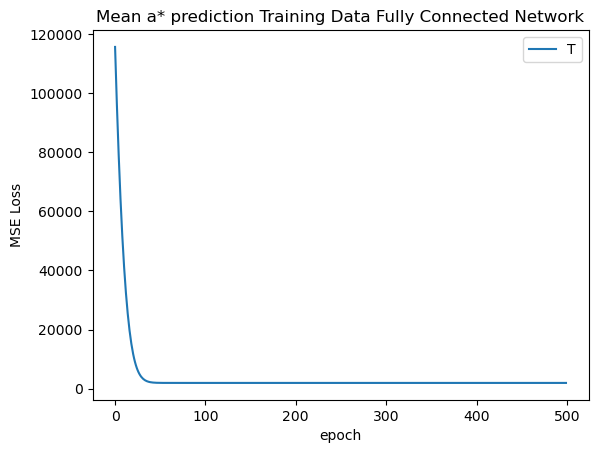

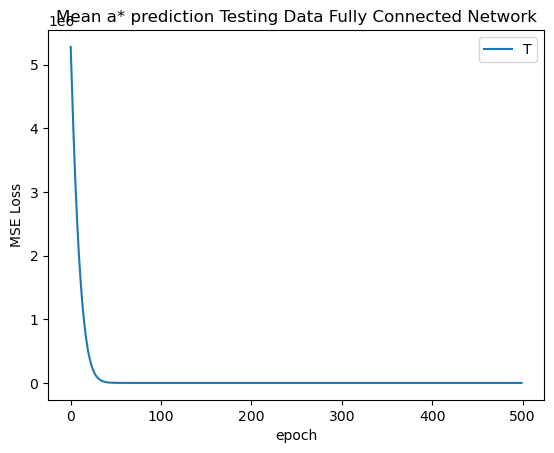

In [137]:
import torch.nn as nn
#Model architecture
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=49152, out_features=500),
            nn.Tanh()
        ) 
        
        # First fully connected layer
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=500, out_features=250),
            nn.ReLU()
        ) 
        
        # First fully connected layer
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=250, out_features=100),
            nn.Tanh()
        ) 
        
        #Linear Output layer
        self.fc4 = nn.Linear(in_features=100, out_features=1)
        
    def forward(self, x):
        z = self.fc1(x)
        z = self.fc2(z)
        z = self.fc3(z)
        z = self.fc4(z)
        z = torch.squeeze(z)
        return z

# Code to define GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)


batch_size = 100
num_epochs = 500
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)

model = FCN()
model = model.float()
model.to(device)

train_data = train_data.to(device)
test_data = test_data.to(device)

error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_a[index*batch_size:(index+1)*batch_size]

        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_a
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean a* prediction Training Data Fully Connected Network")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean a* prediction Testing Data Fully Connected Network")
plt.legend("Testing Loss")
plt.show()

# Predicting mean b* using Fully Connected Network

Device cpu
batch_size: 100
num_epochs: 500
learning_rate: 0.01
batches: 6
optimizer: Adam
Loss function: MSELoss
FCN(
  (fc1): Sequential(
    (0): Linear(in_features=49152, out_features=500, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=500, out_features=250, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=250, out_features=100, bias=True)
    (1): Tanh()
  )
  (fc4): Linear(in_features=100, out_features=1, bias=True)
)
Epoch: 0, Loss: 186711.2187500, Testing Loss: 8606225.000
Epoch: 25, Loss: 18893.4316406, Testing Loss: 797751.188
Epoch: 50, Loss: 1416.1789551, Testing Loss: 17766.256
Epoch: 75, Loss: 945.2249756, Testing Loss: 0.022
Epoch: 100, Loss: 942.3790283, Testing Loss: 117.968
Epoch: 125, Loss: 942.3786621, Testing Loss: 126.450
Epoch: 150, Loss: 942.3798828, Testing Loss: 126.580
Epoch: 175, Loss: 942.3809814, Testing Loss: 126.585
Epoch: 200, Loss: 942.3820190, Testing Loss: 126.591
Epoch: 225, Loss: 942.38

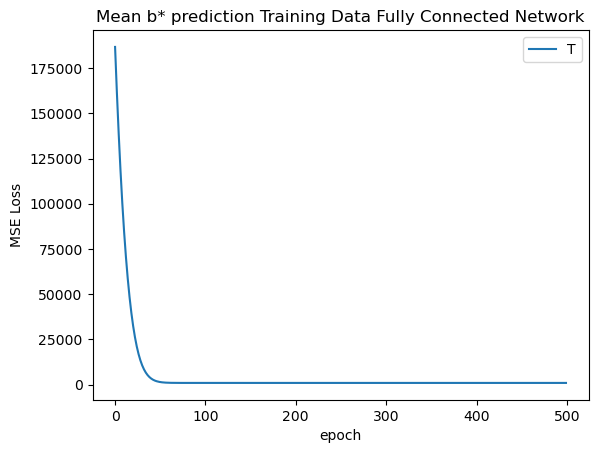

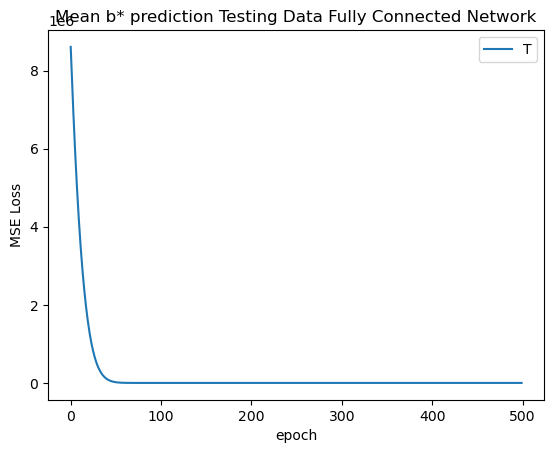

In [142]:
import torch.nn as nn
#Model architecture
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=49152, out_features=500),
            nn.Tanh()
        ) 
        
        # First fully connected layer
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=500, out_features=250),
            nn.ReLU()
        ) 
        
        # First fully connected layer
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=250, out_features=100),
            nn.Tanh()
        ) 
        
        #Linear Output layer
        self.fc4 = nn.Linear(in_features=100, out_features=1)
        
    def forward(self, x):
        z = self.fc1(x)
        z = self.fc2(z)
        z = self.fc3(z)
        z = self.fc4(z)
        z = torch.squeeze(z)
        return z

# Code to define GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)


batch_size = 100
num_epochs = 500
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)

model = FCN()
model = model.float()
model.to(device)

train_data = train_data.to(device)
test_data = test_data.to(device)

error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_b[index*batch_size:(index+1)*batch_size]

        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_b
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean b* prediction Training Data Fully Connected Network")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean b* prediction Testing Data Fully Connected Network")
plt.legend("Testing Loss")
plt.show()

# Convolution Neural Network

In [128]:
#Reshaping the dataset from (128*128*3) to (3*128*128) for training CNNs

In [143]:
new_train_L=[]
for i in range(682):
    f=[]
    for channel in range(3):
        rows=[]
        for row in range(128):
            columns=[]
            for column in range(128):
                columns.append(float(train_L[i][row][column][channel]))
            columns=np.array(columns)
            rows.append(columns)
        rows=np.array(rows)
        f.append(rows)
    f=np.array(f)
    new_train_L.append(torch.tensor(f,dtype=torch.float32))
new_train_L=torch.stack(new_train_L, dim=0)

In [144]:
new_test_L=[]
for i in range(293):
    f=[]
    for channel in range(3):
        rows=[]
        for row in range(128):
            columns=[]
            for column in range(128):
                columns.append(float(test_L[i][row][column][channel]))
            columns=np.array(columns)
            rows.append(columns)
        rows=np.array(rows)
        f.append(rows)
    f=np.array(f)
    new_test_L.append(torch.tensor(f,dtype=torch.float32))
new_test_L=torch.stack(new_test_L, dim=0)

In [147]:
class Convnet(nn.Module):   
    def __init__(self):
        super(Convnet, self).__init__()

        self.cnn_layers = Sequential(
            Con3v2d(3, 3, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(3),
            ReLU(inplace=True),
            Conv2d(3, 3, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(3),
            ReLU(inplace=True),
            Conv2d(3, 3, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(3),
            ReLU(inplace=True),
            Conv2d(3, 3, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(3),
            ReLU(inplace=True)
        )

        self.linear_layers = Sequential(
            Linear(3 * 8 * 8, 1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = torch.squeeze(x)
        return x

# Predicting mean a* using CNN

Device cpu
batch_size: 100
num_epochs: 500
learning_rate: 0.01
batches: 6
optimizer: Adam
Loss function: MSELoss
Convnet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=192, out_features=1, bias=Tru

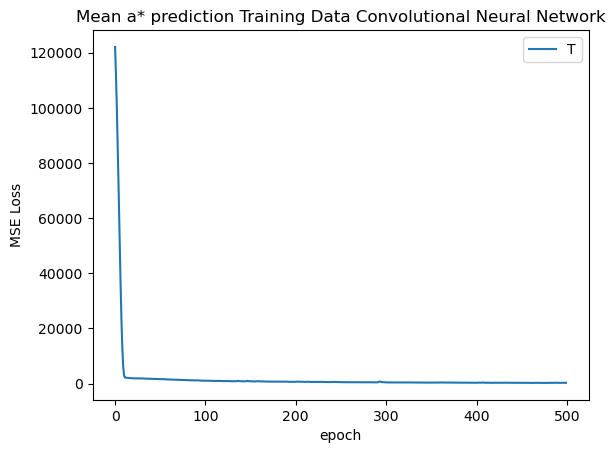

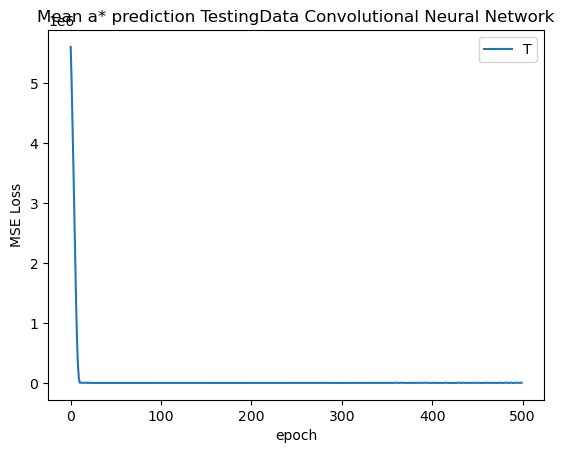

In [148]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)


batch_size = 100
num_epochs = 500
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)

model = Convnet()
model = model.float()
model.to(device)

train_data=copy.deepcopy(new_train_L)
train_data = train_data.to(device)
test_data = copy.deepcopy(new_test_L)
test_data = test_data.to(device)

error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_a[index*batch_size:(index+1)*batch_size]

        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_a
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean a* prediction Training Data Convolutional Neural Network")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean a* prediction TestingData Convolutional Neural Network")
plt.legend("Testing Loss")

plt.show()

# Predicting mean b* using CNN

Device cpu
batch_size: 100
num_epochs: 500
learning_rate: 0.01
batches: 6
optimizer: Adam
Loss function: MSELoss
Convnet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=192, out_features=1, bias=Tru

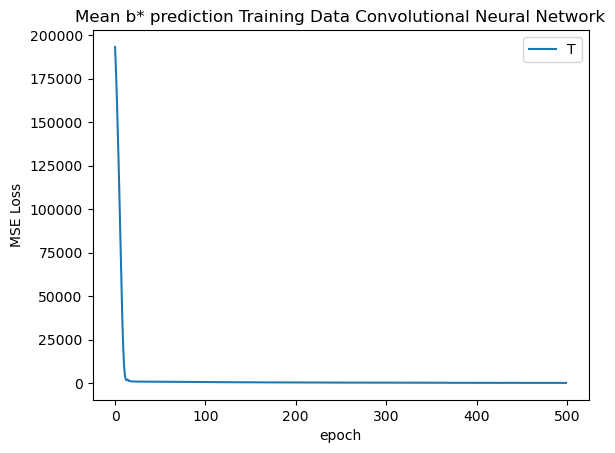

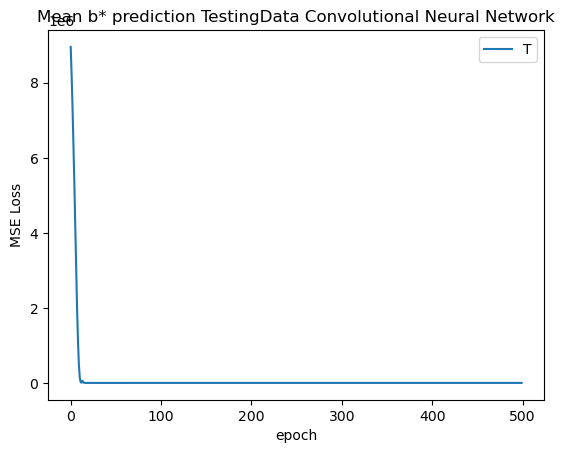

In [150]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)


batch_size = 100
num_epochs = 500
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)

model = Convnet()
model = model.float()
model.to(device)

train_data=copy.deepcopy(new_train_L)
train_data = train_data.to(device)
test_data = copy.deepcopy(new_test_L)
test_data = test_data.to(device)

error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_b[index*batch_size:(index+1)*batch_size]

        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_b
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean b* prediction Training Data Convolutional Neural Network")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean b* prediction TestingData Convolutional Neural Network")
plt.legend("Testing Loss")
plt.show()

# Convolution Neural Network for mean a* prediction with scaled input data

In [146]:
#Scaling the input data

In [151]:
new_train_L=(new_train_L)/torch.max(new_train_L)
new_test_L=(new_test_L)/torch.max(new_test_L)

Device cpu
batch_size: 100
num_epochs: 500
learning_rate: 0.01
batches: 6
optimizer: Adam
Loss function: MSELoss
Convnet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=192, out_features=1, bias=Tru

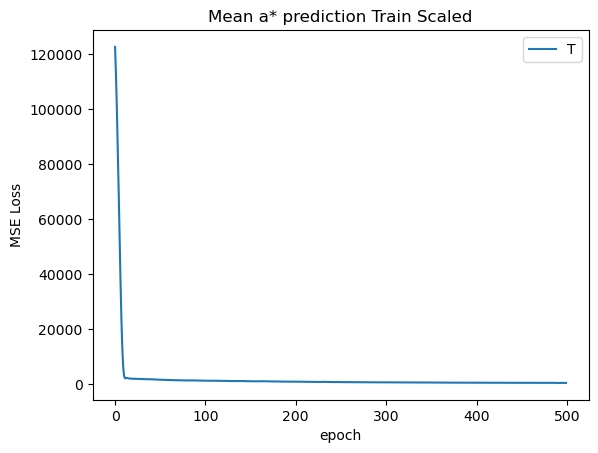

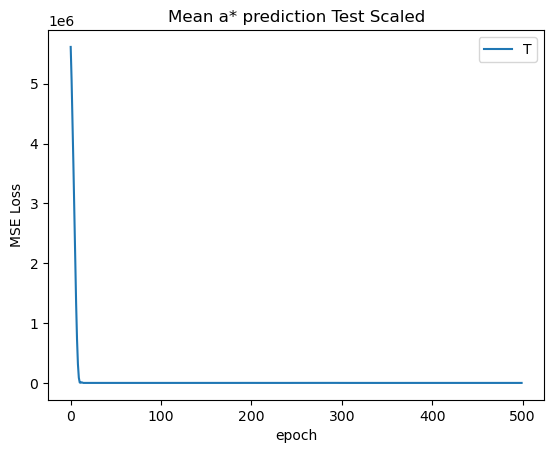

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)


batch_size = 100
num_epochs = 500
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)

model = Convnet()
model = model.float()
model.to(device)

train_data=copy.deepcopy(new_train_L)
train_data = train_data.to(device)
test_data = copy.deepcopy(new_test_L)
test_data = test_data.to(device)

error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_a[index*batch_size:(index+1)*batch_size]

        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_a
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean a* prediction Train Scaled")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean a* prediction Test Scaled")
plt.legend("Testing Loss")

plt.show()

# Convolution Neural Network for mean b* prediction with scaled input data

Device cpu
batch_size: 100
num_epochs: 500
learning_rate: 0.01
batches: 6
optimizer: Adam
Loss function: MSELoss
Convnet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=192, out_features=1, bias=Tru

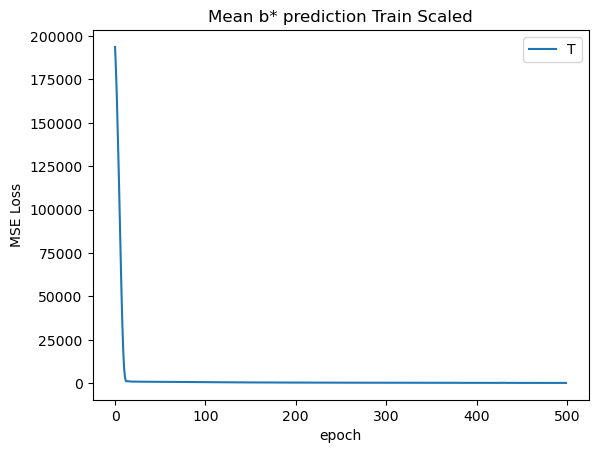

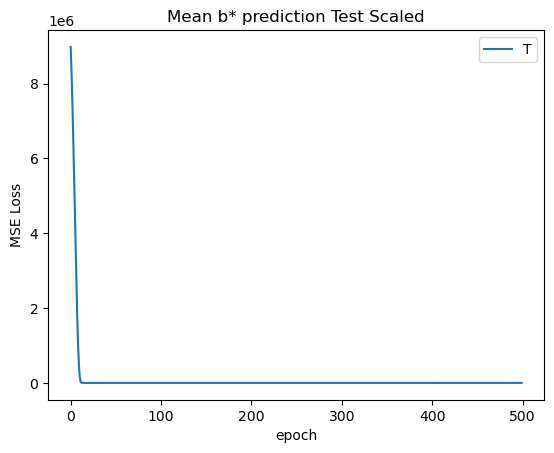

In [153]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)


batch_size = 100
num_epochs = 500
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)

model = Convnet()
model = model.float()
model.to(device)

train_data=copy.deepcopy(new_train_L)
train_data = train_data.to(device)
test_data = copy.deepcopy(new_test_L)
test_data = test_data.to(device)

error = nn.MSELoss()  # This works well with the linear output layer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_b[index*batch_size:(index+1)*batch_size]

        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_b
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    if epoch%25==0:
        print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean b* prediction Train Scaled")
plt.legend("Training Loss")
plt.show()

plt.figure()
plt.plot(loss_test_hist)
plt.xlabel("epoch")
plt.ylabel("MSE Loss")
plt.title("Mean b* prediction Test Scaled")
plt.legend("Testing Loss")

plt.show()